In [1]:
#!ls Data

In [2]:
cd ../..

/Users/eddielin/Documents/Flatiron/Projects/Microsoft_movies_project/microsoft_movies


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
#import the four relevent schemas to the budget and genres
tndb_df = pd.read_csv('Data/tn.movie_budgets.csv')
tn_mov_df = pd.read_csv('Data/tmdb.movies.csv')
akas_df = pd.read_csv('Data/imdb.title.akas.csv')
basics_df = pd.read_csv('Data/imdb.title.basics.csv')

In [5]:
#removed all punctuations to movie titles on the two schemas
tndb_df["Mov_name"] = tndb_df['movie'].str.lower().str.replace('[ \'\:\,\.]','').astype(str)
tn_mov_df["Mov_name"] = tn_mov_df['title'].str.lower().str.replace('[ \'\:\,\.]','').astype(str)


#creates new column with only the release year of the movie
tn_mov_df['release_year'] = tn_mov_df['release_date'].astype(str).str[:4]



In [6]:
#merged the two schemas with constant id
#rt_df = info_df.merge(reviews_df, on='id')
imdb_df = basics_df.merge(akas_df,left_on ='tconst',right_on = "title_id",how = "inner") 

#merged tn and tndb to create new db, keeping values only the same movie names 
tn_df = tn_mov_df.merge(tndb_df, on = 'Mov_name', how = 'inner')

In [7]:
#created new column with movie names stripped
imdb_df['Mov_name'] = imdb_df['primary_title'].str.lower().str.replace('[ \'\:\,\.]','').astype(str)



In [8]:
#create a new colum to include name and year of release
imdb_df['name_year'] = imdb_df['Mov_name'] + imdb_df['start_year'].astype(str)
tn_df['name_year'] = tn_df['Mov_name'] + tn_df['release_year'].astype(str)

In [9]:
#new cost df joining imdb and tn keeping only values with the same name,year and has cost data
budget_df = tn_df.merge(imdb_df, on = 'name_year', how = 'inner')

In [10]:
#created two new columns to convert money strings to ints without punctuations
budget_df["domestic_gross_$"] = budget_df['domestic_gross'].str.lower().str.replace('[ \'\:\,\.\$]','').astype(int)
budget_df["worldwide_gross_$"] = budget_df['worldwide_gross'].str.lower().str.replace('[ \'\:\,\.\$]','').astype(int)

In [11]:
#new column converting production budget into a usable format
budget_df["production_$"] = budget_df['production_budget'].str.lower().str.replace('[ \'\:\,\.\$]','').astype(int)

#new column with the sum of the gross
budget_df['international_gross'] = budget_df["worldwide_gross_$"] - budget_df["domestic_gross_$"]

#new colum with net value of the movie
budget_df['net_gain'] = budget_df['worldwide_gross_$'] - budget_df['production_$']


In [12]:
#check the colums of budget_Df
#budget_df.columns

In [13]:
#new df with only relevant info and sorted by the total gross
budget_df_simplified = budget_df[['movie','genres','production_budget','domestic_gross','worldwide_gross','net_gain','domestic_gross_$','worldwide_gross_$','international_gross']]
all_budget_df = budget_df_simplified.drop_duplicates(keep ='first').copy()

display(budget_df_simplified.head(3))
all_budget_df.head(3)

,movie,genres,production_budget,domestic_gross,worldwide_gross,net_gain,domestic_gross_$,worldwide_gross_$,international_gross
0,How to Train Your Dragon,"Action,Adventure,Animation","$165,000,000","$217,581,232","$494,870,992",329870992,217581232,494870992,277289760
1,How to Train Your Dragon,"Action,Adventure,Animation","$165,000,000","$217,581,232","$494,870,992",329870992,217581232,494870992,277289760
2,How to Train Your Dragon,"Action,Adventure,Animation","$165,000,000","$217,581,232","$494,870,992",329870992,217581232,494870992,277289760


,movie,genres,production_budget,domestic_gross,worldwide_gross,net_gain,domestic_gross_$,worldwide_gross_$,international_gross
0,How to Train Your Dragon,"Action,Adventure,Animation","$165,000,000","$217,581,232","$494,870,992",329870992,217581232,494870992,277289760
44,Iron Man 2,"Action,Adventure,Sci-Fi","$170,000,000","$312,433,331","$621,156,389",451156389,312433331,621156389,308723058
82,Inception,"Action,Adventure,Sci-Fi","$160,000,000","$292,576,195","$835,524,642",675524642,292576195,835524642,542948447


In [14]:
#splits the genres and creates a list to be exploded
all_budget_df['genres'] = all_budget_df['genres'].str.strip().str.split(',')

In [15]:
#exploded the genres column to isolate genres
single_category_budget_df = all_budget_df.explode('genres')

In [16]:
#chcanges the net_cost to int type
single_category_budget_df['net_gain'] = single_category_budget_df['net_gain'].astype(int)

In [17]:
#creates new column for earnings in millions
single_category_budget_df['earnings_in_millions'] = single_category_budget_df['net_gain']/1000000


In [18]:
#new colums for domestic and worldwide gross in millions
single_category_budget_df['domestic_earnings_millions'] = single_category_budget_df['domestic_gross_$']/1000000
single_category_budget_df['international_earnings_millions'] = single_category_budget_df['international_gross']/1000000


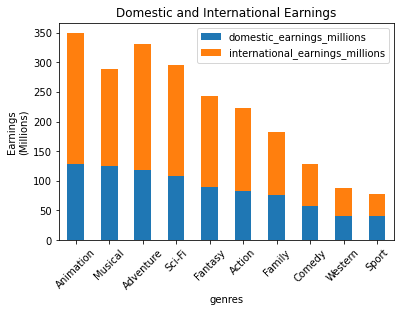

In [19]:

ww_earn_split = single_category_budget_df.groupby('genres')[['domestic_earnings_millions','international_earnings_millions']].mean().sort_values(by='domestic_earnings_millions', ascending = False).head(10)
ww_earn_split.plot(kind ='bar', stacked = True, xlabel ='genres', ylabel='Earnings\n(Millions)',rot = 45, title = "Domestic and International Earnings");


In [20]:
#creates seperate data with only the higest earning genres worldwide
top_10_cat = single_category_budget_df.groupby('genres')['earnings_in_millions'].mean().sort_values(ascending = False).head(10)

#converts to dataframe
top_10_cat_df = top_10_cat.to_frame()
top_10_cat_df.reset_index(inplace = True)
top_10_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genres                10 non-null     object 
 1   earnings_in_millions  10 non-null     float64
dtypes: float64(1), object(1)
memory usage: 288.0+ bytes


In [21]:
top_10_cat_df.head()

,genres,earnings_in_millions
0,Animation,259.335013
1,Musical,233.589414
2,Adventure,231.129183
3,Sci-Fi,214.024724
4,Fantasy,166.877799


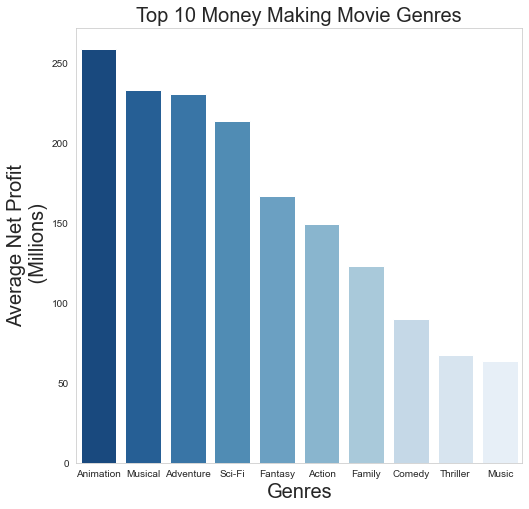

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {'axes.grid' : False})
#plot scatter plot: weighted average vs avg number of votes vs avg total gross
plt.figure(figsize = (8,8))
sns.barplot(data=top_10_cat_df, x='genres',y= 'earnings_in_millions', palette="Blues_r")
plt.xlabel('Genres', size=20)
plt.ylabel('Average Net Profit\n (Millions)', size=20)
plt.title('Top 10 Money Making Movie Genres', size=20)
             
plt.savefig('eddie.png', dpi=80, bbox_inches='tight')

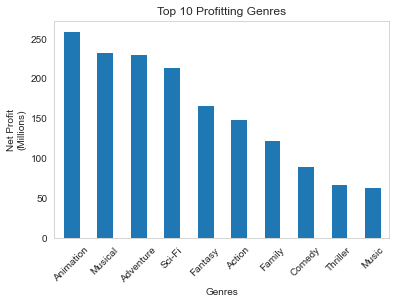

In [23]:
#plots the top 10 categories
top_10_cat.plot.bar(xlabel = 'Genres',ylabel = 'Net Profit\n(Millions)',title= "Top 10 Profitting Genres",rot = 45);
